In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import numpy as np

# Add project root to path
sys.path.append(os.path.abspath(".."))
from src.engine import PairsTradingEngine

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_context("talk")


In [2]:
# Initialize engine
engine = PairsTradingEngine(data_dir="../data/", lookback=60)

# Run cointegration detection
pairs = engine.find_cointegrated_pairs()
print("Cointegrated pairs:", pairs)

# Pick one pair (e.g., first one)
x, y = pairs[0]
signals = engine.generate_signals(x, y)

# Preview
signals[['spread', 'zscore', 'signal', 'position']].tail()


Cointegrated pairs: [('COP', 'CVX'), ('COP', 'JNJ'), ('COP', 'KO'), ('COP', 'PEP'), ('CVX', 'JNJ'), ('CVX', 'KO'), ('CVX', 'PEP'), ('KO', 'PG'), ('KO', 'XOM'), ('PEP', 'XOM')]


c:\Users\sriha\Downloads\resume\pairs-trading\src\engine.py:136: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  zdf['position'] = zdf['signal'].replace(to_replace=0, method='ffill').fillna(0)


,spread,zscore,signal,position
timestamp,,,,
2024-12-23,40.612157,0.141486,0,-1
2024-12-24,40.711740,0.143064,0,-1
2024-12-26,41.074713,0.186917,0,-1
2024-12-27,41.063422,0.163476,0,-1
2024-12-30,39.979926,-0.063911,0,-1


In [3]:
def backtest_pair(signals, prices, x, y, capital=1.0):
    df = signals.copy()
    px = prices[[x, y]].loc[df.index].ffill()

    # Hedge ratio using linear regression
    hedge_ratio = px[y].sub(px[x] * (px[y] / px[x]).mean())  # simplified hedge

    # Position: +1 = long spread (long y, short x), -1 = short spread
    df['px_x'] = px[x]
    df['px_y'] = px[y]

    # Trade returns
    df['ret_x'] = df['px_x'].pct_change()
    df['ret_y'] = df['px_y'].pct_change()

    df['spread_ret'] = df['position'].shift(1) * (df['ret_y'] - df['ret_x'])

    df['cum_return'] = (1 + df['spread_ret'].fillna(0)).cumprod()

    return df


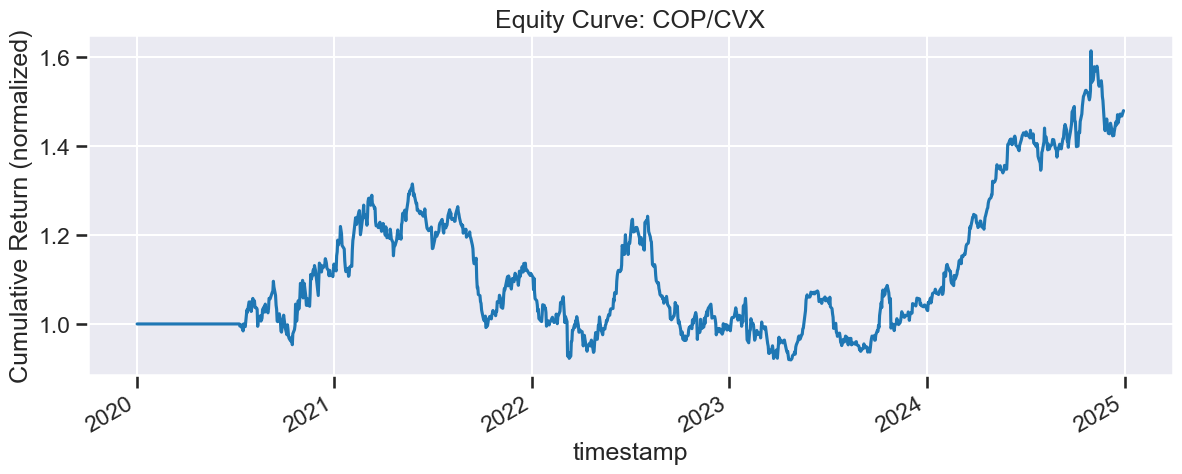

Total Return: 47.95%
Sharpe Ratio: 0.51
Max Drawdown: -30.09%


In [4]:
# Run backtest
prices = engine.get_price_data()
bt = backtest_pair(signals, prices, x, y)

# Plot equity curve
bt['cum_return'].plot(figsize=(14, 5), title=f"Equity Curve: {x}/{y}")
plt.ylabel("Cumulative Return (normalized)")
plt.show()

# Final metrics
total_return = bt['cum_return'].iloc[-1] - 1
sharpe = bt['spread_ret'].mean() / bt['spread_ret'].std() * np.sqrt(252)
drawdown = (bt['cum_return'] / bt['cum_return'].cummax()) - 1

print(f"Total Return: {total_return:.2%}")
print(f"Sharpe Ratio: {sharpe:.2f}")
print(f"Max Drawdown: {drawdown.min():.2%}")
